<a href="https://colab.research.google.com/github/isakdiaz/deeplabv3-tree-segmentation/blob/master/treeseg_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pprint
import json
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Check GPU or TPU Enabled

In [39]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('✅ Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  print("❌ No TPU Found! At the top click Runtime -> Change Runtime Type -> Hardware Accelerator -> TPU")

❌ No TPU Found! At the top click Runtime -> Change Runtime Type -> Hardware Accelerator -> TPU


In [40]:
# Check if running on GPU
import tensorflow as tf
gpu_location = tf.test.gpu_device_name()
if gpu_location:
  print("✅ GPU found at " + gpu_location)
else:
  print("❌ No GPU Found!. At the top click Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU")

✅ GPU found at /device:GPU:0


# Clone The Repo

In [7]:
!git clone https://github.com/isakdiaz/deeplabv3-tree-segmentation.git

Cloning into 'deeplabv3-tree-segmentation'...
remote: Enumerating objects: 2025, done.
remote: Total 2025 (delta 0), reused 0 (delta 0), pack-reused 2025
Receiving objects: 100% (2025/2025), 497.61 MiB | 10.08 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [17]:
!cd & ls deeplabv3-tree-segmentation

data		data.py  metrics.py  predict.py       Readme.md
data_augmented	eval.py  model.py    prep_renders.py  train.py


## Confirm that augmented dataset has already been generated

In [38]:
num_train = !cd & ls deeplabv3-tree-segmentation/data_augmented/train/image | wc -l
num_test = !cd & ls deeplabv3-tree-segmentation/data_augmented/test/image | wc -l
print(f"There are {num_imgs[0]} images in the training set and {num_test[0]} in the test set.")

There are 540 images in the training set and 10 in the test set.


# Train the Model

In [43]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

In [44]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

def SqueezeAndExcite(inputs, ratio=8):
    init = inputs
    filters = init.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = init * se
    return x

def ASPP(inputs):
    """ Image Pooling """
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(256, 1, padding="same", use_bias=False)(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    """ 1x1 conv """
    y2 = Conv2D(256, 1, padding="same", use_bias=False)(inputs)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    """ 3x3 conv rate=6 """
    y3 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=6)(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    """ 3x3 conv rate=12 """
    y4 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=12)(inputs)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    """ 3x3 conv rate=18 """
    y5 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(256, 1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def deeplabv3_plus(shape):
    """ Input """
    inputs = Input(shape)

    """ Encoder """
    encoder = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

    image_features = encoder.get_layer("conv4_block6_out").output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    x_b = encoder.get_layer("conv2_block2_out").output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])
    x = SqueezeAndExcite(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SqueezeAndExcite(x)

    x = UpSampling2D((4, 4), interpolation="bilinear")(x)
    x = Conv2D(1, 1)(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)
    return model

In [45]:

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


In [56]:
""" Global parameters """
H = 512
W = 512

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*png")))
    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


In [58]:
  """ Seeding """
  np.random.seed(42)
  tf.random.set_seed(42)

  """ Directory for storing files """
  create_dir("files")

  """ Hyperparameters """
  batch_size = 4
  lr = 1e-4
  num_epochs = 20
  model_path = os.path.join("files", "model.h5")
  csv_path = os.path.join("files", "data.csv")

  """ Dataset """
  dataset_path = "deeplabv3-tree-segmentation/data_augmented"
  train_path = os.path.join(dataset_path, "train")
  valid_path = os.path.join(dataset_path, "test")

  print(train_path)
  train_x, train_y = load_data(train_path)
  print(len(train_x))
  print(len(train_y))

  train_x, train_y = shuffling(train_x, train_y)
  valid_x, valid_y = load_data(valid_path)

  print(f"Train: {len(train_x)} - {len(train_y)}")
  print(f"Valid: {len(valid_x)} - {len(valid_y)}")

  train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
  valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

  """ Model """
  model = deeplabv3_plus((H, W, 3))
  model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

  callbacks = [
      ModelCheckpoint(model_path, verbose=1, save_best_only=True),
      ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
      CSVLogger(csv_path),
      TensorBoard(),
      EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
  ]
  
  tf.config.list_physical_devices()

  model.fit(
      train_dataset,
      epochs=num_epochs,
      validation_data=valid_dataset,
      callbacks=callbacks
  )

deeplabv3-tree-segmentation/data_augmented/train
540
540
Train: 540 - 540
Valid: 10 - 10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
135/135 [==============================] - 60s 280ms/step - loss: 0.2631 - dice_coef: 0.7369 - iou: 0.6085 - recall_2: 0.9419 - precision_2: 0.7075 - val_loss: 0.8944 - val_dice_coef: 0.1034 - val_iou: 0.0545 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.89436, saving model to files/model.h5
Epoch 2/20
135/135 [==============================] - 35s 257ms/step - loss: 0.1117 - dice_coef: 0.8883 - iou: 0.8089 - recall_2: 0.9534 - precision_2: 0.9093 - val_loss: 0.9551 - val_dice_coef: 0.0451 - val_iou: 0.0231 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.89436
Epoch 3/20
135/135 [==============================] - 35s 257ms/step - loss: 0.0740 - dice_coef: 0.9260 - iou: 0.8695 - recall_2: 0.9686 - precision_2: 0.9362 - val_loss: 0.9956 - val_dice_coef: 0.0042 - val_iou: 0.0021 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00

Epoch 00003: val_loss did not im

In [49]:
!ls deeplabv3-tree-segmentation/data_augmented/train

image  mask


In [65]:
!ls -hs files

total 206M
4.0K data.csv  206M model.h5


# Evaluate Model

In [71]:
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tqdm import tqdm

In [72]:
def save_results(image, mask, y_pred, save_image_path):
    ## i - m - yp - yp*i
    line = np.ones((H, 10, 3)) * 128

    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    mask = mask * 255

    y_pred = np.expand_dims(y_pred, axis=-1)    ## (512, 512, 1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)  ## (512, 512, 3)

    masked_image = image * y_pred
    y_pred = y_pred * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred, line, masked_image], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [82]:
np.random.seed(42)
tf.random.set_seed(42)

""" Directory for storing files """
create_dir("results")

""" Loading model """
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model("files/model.h5")

""" Load the dataset """
dataset_path = "deeplabv3-tree-segmentation/data_augmented"
valid_path = os.path.join(dataset_path, "test")
test_x, test_y = load_data(valid_path)
print(f"Test: {len(test_x)} - {len(test_y)}")

""" Evaluation and Prediction """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extract the name """
    name = x.split("/")[-1].split(".")[0]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    x = image/255.0
    x = np.expand_dims(x, axis=0)

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = mask/255

    """ Prediction """
    y_pred = model.predict(x)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)

    """ Saving the prediction """
    save_image_path = f"results/{name}.png"
    save_results(image, mask, y_pred, save_image_path)

    """ Flatten the array """
    mask = mask.flatten()
    y_pred = y_pred.flatten()

    """ Calculating the metrics values """
    acc_value = accuracy_score(mask, y_pred)
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

""" Metrics values """
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv")

Test: 10 - 10


 20%|██        | 2/10 [00:02<00:08,  1.07s/it]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

Accuracy: 0.99204
F1: 0.87366
Jaccard: 0.84955
Recall: 0.87740
Precision: 0.87016


In [84]:
!ls results

pinetree_00000_0.png  pinetree_00044_0.png  pinetree_00080_0.png
pinetree_00010_0.png  pinetree_00045_0.png  pinetree_00083_0.png
pinetree_00022_0.png  pinetree_00053_0.png
pinetree_00039_0.png  pinetree_00070_0.png


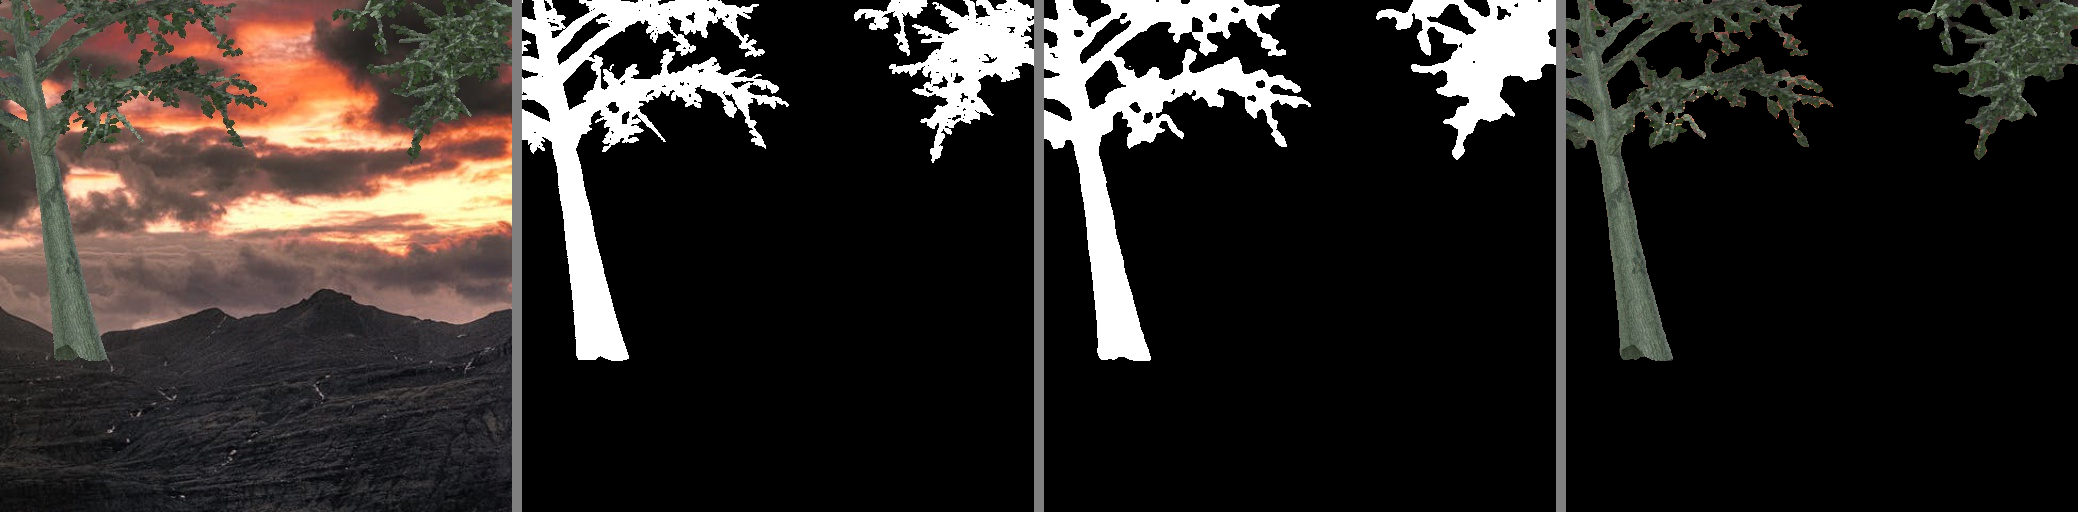

In [94]:
from IPython.display import Image
Image(filename='results/pinetree_00080_0.png')

 